<h1><center>Pretty Pictures with Numpy</center></h1>
<center>Making Fractals for Dynamical Systems Research using Numpy and Matplotlib</center>

<h2><center>About Me</center></h2>
- Masters Degree in "Applied and Computational Mathematics" from UMD

- Currently a Systems/Algorithm Engineer at Black River Systems
    - Work on small research grants for Intelligence, Surveillance + Reconnaisance defense contracts
    - Mix of reading CS/Math papers and implementing prototypes

- Also part time Data Science consultant for financial data consulting company
    - Work with Apache Spark (in Scala), also making a Slackbot

<h1><center>Dynamical Systems</center></h1>
- Dynamical Systems is the study of the behavior of repeated maps of the form <center>$z_n \mapsto z_{n+1} = f_{\alpha_1,\ldots, \alpha_n}(z_n)$</center> where $f_{\alpha_1,\ldots, \alpha_n} : S \rightarrow S$

- The ultimate goal would be a characterization of the "long term" behavior of every point $x \in S$ as the parameters $\alpha_i$ vary

- My graduate research was focused on the family <center>$z_n \mapsto f_{c,\beta} (z_n) = z_n^2 + c + \frac{\beta}{\overline{z_n}^2} = z_{n+1}$</center>
where $f_{c,\beta} : \mathbb{C} \rightarrow \mathbb{C}$

- This family is interesting because it is non-holomorphic blah, blah, blah...

<h1><center>Types of Orbits</center></h1>
- An orbit of a some point $x$ under some map $f$ is the set of points <center>$\operatorname{Orb}(x,f) = \{x, f(x), f(f(x)) = f^2(x), \ldots\}$</center>

- Orbits can be unbounded: $\forall K \in \mathbb{R}, \exists n \in \mathbb{N}$ such that $|f^n(x)| > B$ 
    - e.g. 2 under $f(x) = x^2$

- Orbits can be bounded ($\exists B$ such that $|f^n(x)| < B$, $\forall n \in \mathbb{N}$)
    - Fixed: 0 under $f(x) = x^2$ : $\{0, 0, \ldots\}$
    - Periodic: -1 under $f(x) = x^2 - 1$ : $\{-1, 0, -1, 0, \ldots\}$
    - Attracting: 1 under $f(x) = \frac{x}{2}$ : $\{1, \frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \ldots\}$
    - Other: pre-periodic, pre-fixed, CHAOTIC

<h1><center>Escape Images</center></h1>
- So given some map, we want to be able to get an idea of what the long term behavior is for each of its points as parameters change

- One way to do this is to create an "escape image" which takes each point on the 2D plane as an initial condition (represented by a pixel) and records how long it took for the map, under that initial condition, to escape

- Here is an escape image you might have seen before:

<IPython.core.display.Javascript object>


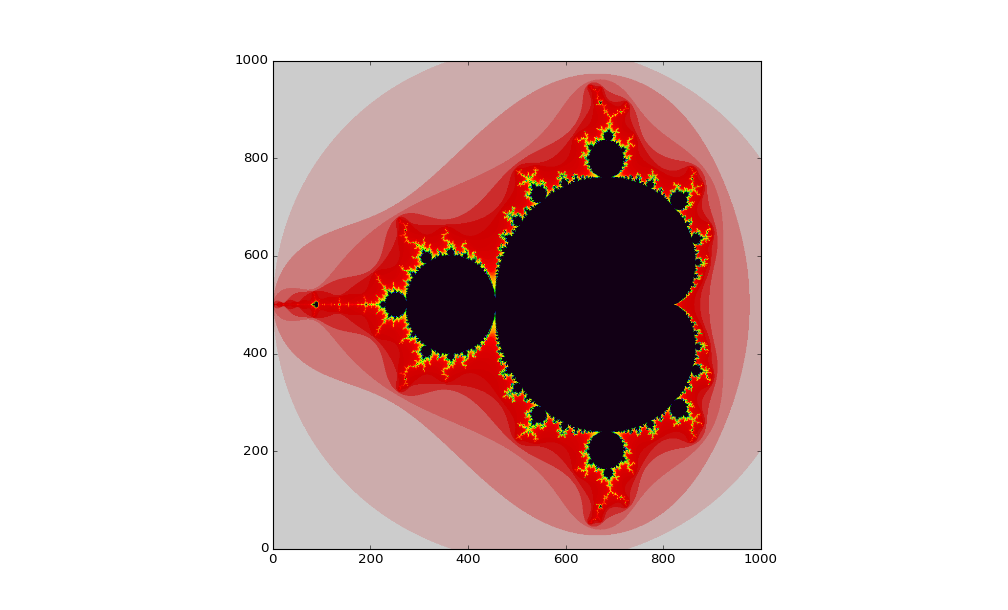

In [20]:
escImgParam(fn=lambda x,c: x*x + c, xmin=-2, xmax=.75, ymin=-1.25,
            ymax=1.25, colorMap=favColorMap)

<h1><center>How to Make the Mandelbrot Set</center></h1>
- The Mandelbrot Set is a Parameter Space Escape Image for the map <center>$f_c(z) = z^2 + c$</center>
such that $f : \mathbb{C} \rightarrow \mathbb{C}$
- "Parameter Space" means that each pixel is representing a value for the parameter $c \in \mathbb{C}$
- So what we need to do is to iterate the map $f_c(0)$ some number of times for each pixel (value for $c$) in our plane and determine how "fast" that point escapes
- We then color that pixel with the relative amount of time it took for that point to escape
    - We iterate on the value 0 for technical reasons (it's special)
    - In this case, "escape" means $|f^n_c(0)| > 2$

In [9]:
%matplotlib notebook
%run escapeImages.py
favColorMap = "spectral"

<h1><center></center></h1>

# Julia Set
Phase Space escape image for $x \mapsto x^2 - 1$

<IPython.core.display.Javascript object>


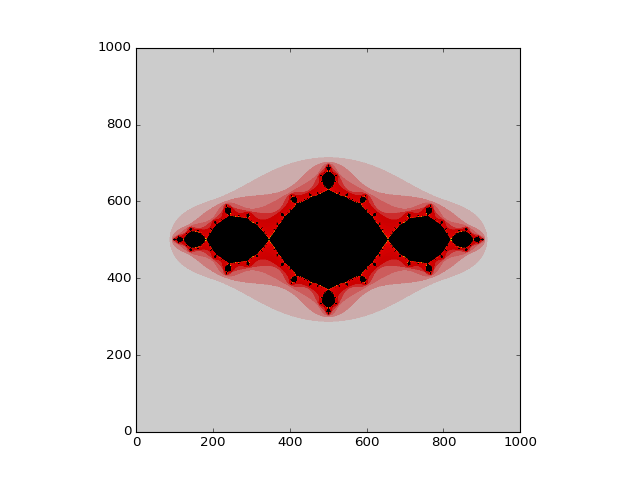

In [10]:
escImgPhase(fn=lambda x: x*x - 1, n=1000, m=1000, colorMap=favColorMap)

# Mandelbrot Set
Parameter space image for the map $x \mapsto x^2 + c$

<IPython.core.display.Javascript object>


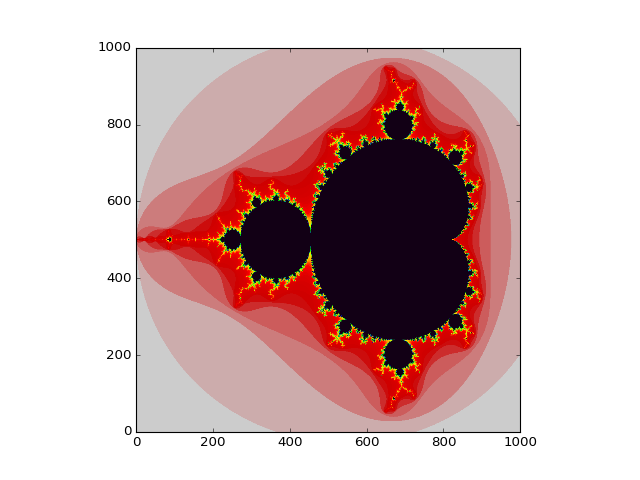

In [11]:
escImgParam(n=1000, m=1000, xmin=-2, xmax=.75, ymin=-1.25,
            ymax=1.25, colorMap=favColorMap)

# Burning Ship Fractal
Parameter space image for the map $\displaystyle z \mapsto \left(|\operatorname{Re}(z)|+i\left|\operatorname{Im}(z)\right|\right)^2 + c$

In [12]:
def bShip(z,c): return (abs(np.real(z)) + abs(np.imag(z))*complex(0,1))**2 + c

<IPython.core.display.Javascript object>


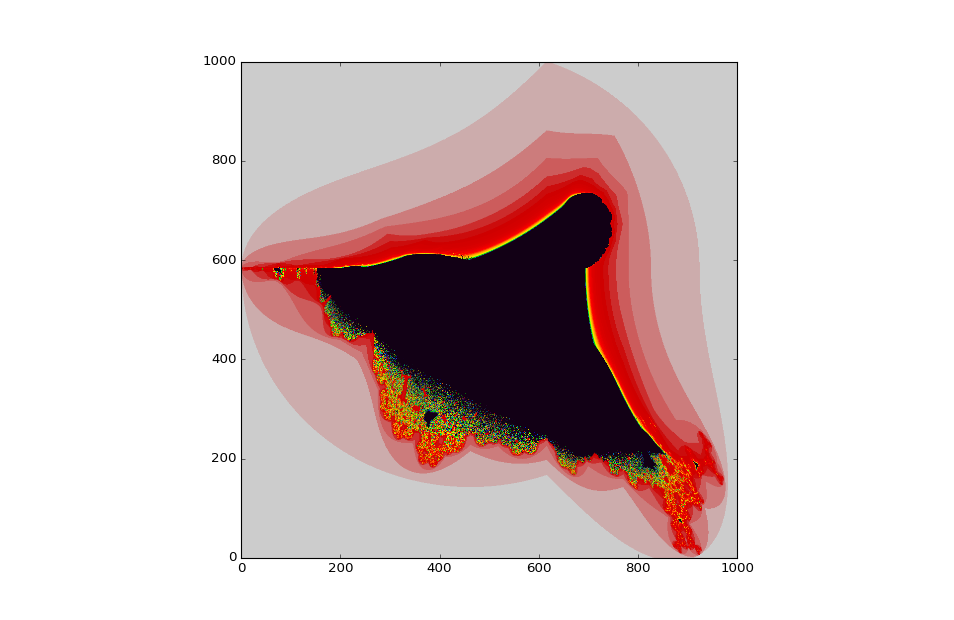

In [15]:
escImgParam("burning_ship2", fn=bShip, n=1000, m=1000, xmin=-2, xmax=1.25, ymin=-1.75, ymax=1.25, colorMap=favColorMap)